# Cars4U Pricing Analysis and Prediction

## Background

Cars4U is a budding tech start-up that aims to break into the pre-owned cars market. Unlike new cars whose prices are certain, various factors determine the price of pre-owned cars and it is important to be able to predict the prices for a chance to grow in the market.

## Objective

This project aims to analyse the available data on used cars, build a linear regression model to effectively predict their prices, and generate insights and recommendations that will help the business devise profitable strategies.

## Data Description

The data provides the different attributes of used cars sold in different locations. The detailed data dictionary is given below:
- **S.No.:** Serial number
- **Name:** Name of the car which includes brand name and model name
- **Location:** Location in which the car is being sold or is available for purchase
- **Year:** Manufacturing year of the car
- **Kilometers_driven:** The total kilometers (a unit used to measure length or distance) driven in the car by the previous owner(s)
- **Fuel_Type:** The type of fuel used by the car (Petrol, Diesel, Electric, CNG, LPG)
- **Transmission:** The type of transmission used by the car (Automatic/Manual)
- **Owner:** Type of ownership
- **Mileage:** The standard mileage offered by the car company in kmpl or km/kg
- **Engine:** The displacement volume of the engine in CC
- **Power:** The maximum power of the engine in bhp
- **Seats:** The number of seats in the car
- **New_Price:** The price of a new car of the same model in dollars
- **Price:** The price of the used car in dollars

## Analysis and Prediction

### Import the required packages

In [832]:
import pandas as pd  #For loading and manipulating the data 
import numpy as np #For numerical computations

# For data visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# To split the data into train and test sets
from sklearn.model_selection import train_test_split

# For data normalisation
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

# For building linear models
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# For measuring the performance of the model
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, mean_absolute_error

### Load the dataset

In [833]:
# Loading the data
cars_df = pd.read_csv('used_cars_data-1.csv')

# Making a copy of the dataset to preserve the integrity of the original one
df = cars_df.copy()

# Displaying the first 5 rows of the dataset
df. head()

,S.No.,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,5.51,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,16.06,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,11.27,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,53.14,17.74


**Observations:**
- The "S.No." column is unnecessary and should be dropped
- The "Mileage" column has different S.I Units (km/kg and kmpl) and should be standardized
- All S.I Units in "Mileage", "Engine" and "Power" are to be removed and values type converted to floats (Mileage and Power) and integers (Engine)

### Exploratory Data Analysis

**Dimension of the data**

In [834]:
# Checking the dimension of the data
df.shape

(7253, 14)

There are 7253 rows and 14 columns in the data

**Dropping the S.No. column**

In [835]:
# Dropping the unnecessary 'S.No.' column
df.drop('S.No.', axis=1, inplace=True)

In [836]:
# Quality check
df.shape

(7253, 13)

**Creating the Mileage_Unit column**

I would be stripping the units from the Mileage column and creating the Mileage_Unit column to house them as a way to standardize the Mileage column.

In [837]:
# function to get the mileage unit
def split_value(variable, needed_index):
    """Function to split a value
    Args:
        variable: a column from the dataset
        needed_index: the index of the needed value in the list created from the split method
    Returns:
        value: the needed value
    """
    try:
        value = variable.split(' ') # creates a list of the space separated value items
        return value[needed_index] # returns the needed value from the list
    except: # this would help bypass null values that could cause an error
        return variable #in case a null value is encountered, return the value as is
    
# Creating the 'Mileage_Unit' column
df['Mileage_Unit'] = df['Mileage'].apply(split_value, needed_index=1) # index 1 represents the mileage unit

**Removing S.I units from the Mileage, Engine and Power columns and Type Conversion**

In [838]:
# function to remove the units from the columns
def remove_unit(column):
    """Function to remove the units from the columns
    Args:
        column: a value in the chosen column from the dataset
    Returns:
        column: the numerical type converted value with the unit removed
    """
    try:
        si_unit = column.split(' ') # creating a list with the value and the unit as list items
        column = float(si_unit[0]) #replacing the initial value with the number and type converting
        return column
    except:
        pass

df['Mileage'] = df['Mileage'].apply(remove_unit) # applying the function to the Mileage column
df['Engine'] = df['Engine'].apply(remove_unit) # applying the function to the Engine column
df['Power'] = df['Power'].apply(remove_unit) # applying the function to the Power column

In [839]:
# Quality check
df.sample(5)

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Mileage_Unit
6463,BMW 3 Series 320d Sport,Ahmedabad,2016,40000,Diesel,Automatic,First,22.69,1995.0,190.00,5.0,54.430,NaN,kmpl
3294,Chevrolet Beat LT,Pune,2011,48000,Petrol,Manual,Second,18.60,1199.0,79.40,5.0,11.300,1.8,kmpl
5901,Ford Ecosport 1.5 DV5 MT Titanium Optional,Mumbai,2014,59000,Diesel,Manual,First,22.70,1498.0,89.84,5.0,11.685,6.5,kmpl
6257,Maruti Swift Dzire VDi,Jaipur,2011,90198,Diesel,Manual,Second,19.30,1248.0,73.90,5.0,7.880,NaN,kmpl
949,Hyundai Verna CRDi SX,Hyderabad,2013,82966,Diesel,Manual,First,16.80,1493.0,110.00,5.0,14.255,7.2,kmpl


**Summary information on the dataset**

In [840]:
# checking column datatypes and number of non-null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7253 entries, 0 to 7252
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               7253 non-null   object 
 1   Location           7253 non-null   object 
 2   Year               7253 non-null   int64  
 3   Kilometers_Driven  7253 non-null   int64  
 4   Fuel_Type          7253 non-null   object 
 5   Transmission       7253 non-null   object 
 6   Owner_Type         7253 non-null   object 
 7   Mileage            7251 non-null   float64
 8   Engine             7207 non-null   float64
 9   Power              7078 non-null   float64
 10  Seats              7200 non-null   float64
 11  New_Price          7253 non-null   float64
 12  Price              6019 non-null   float64
 13  Mileage_Unit       7251 non-null   object 
dtypes: float64(6), int64(2), object(6)
memory usage: 793.4+ KB


- The "Name", "Location", "Fuel_Type", "Transmission", "Owner_Type" and "Mileage_Unit" columns are objects. All other columns are numerical.

**Duplicated values**

In [841]:
# checking for duplicated values
df.duplicated().sum()

1

There is one duplicated row in the dataset

In [842]:
# locating the duplicated rows
df.loc[df.duplicated(keep=False), :]

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Mileage_Unit
6498,Honda City 1.5 E MT,Mumbai,2010,52000,Petrol,Manual,First,17.0,1497.0,118.0,5.0,13.58,NaN,kmpl
6582,Honda City 1.5 E MT,Mumbai,2010,52000,Petrol,Manual,First,17.0,1497.0,118.0,5.0,13.58,NaN,kmpl


In [843]:
# drop the duplicates
df.drop_duplicates(inplace=True)

# reset the index
df.reset_index(drop=True, inplace=True)

In [844]:
# Quality check
df.duplicated().sum()

0

**Empty values**

In [845]:
# Checking for empty values in the dataset
for i in df.columns: #looping through each column
    for row, value in enumerate(df[i]): #looping through each row in the columns 
        if value == ' ': #looking for empty values
            print(f'Empty value found on row: {row}') #printing a message if an empty value is found

No empty values were found in the dataset

**Separating categorical and numerical variables**

In [846]:
# separating the object variables from the dataset
cat_cols = df.select_dtypes(include='object').columns.to_list()
cat_cols

['Name', 'Location', 'Fuel_Type', 'Transmission', 'Owner_Type', 'Mileage_Unit']

In [847]:
# print out all the categories and frequency for each categorical variables
for col in cat_cols:
    print(df[col].value_counts())
    print('_' * 50)

Mahindra XUV500 W8 2WD                  55
Maruti Swift VDI                        49
Maruti Swift Dzire VDI                  42
Honda City 1.5 S MT                     39
Maruti Swift VDI BSIV                   37
                                        ..
Chevrolet Beat LT Option                 1
Skoda Rapid 1.6 MPI AT Elegance Plus     1
Ford EcoSport 1.5 TDCi Ambiente          1
Hyundai i10 Magna 1.1 iTech SE           1
Hyundai Elite i20 Magna Plus             1
Name: Name, Length: 2041, dtype: int64
__________________________________________________
Mumbai        948
Hyderabad     876
Coimbatore    772
Kochi         772
Pune          765
Delhi         660
Kolkata       654
Chennai       591
Jaipur        499
Bangalore     440
Ahmedabad     275
Name: Location, dtype: int64
__________________________________________________
Diesel      3852
Petrol      3324
CNG           62
LPG           12
Electric       2
Name: Fuel_Type, dtype: int64
____________________________________________

**Observations:**
- The most popular car brand is Mahindra XUV500 W8 2WD
- Location has 11 categories and the mode is Mumbai
- Fuel Type has 5 categories and the mode is Diesel
- Transmission has 2 categories and the mode is Manual
- Owner type has 4 categories and the mode is First
- Mileage_Unit has 2 categories and the mode is kmpl

In [848]:
# separating the numerical variables from the dataset
num_cols = df.select_dtypes(include='number').columns.to_list()
num_cols

['Year',
 'Kilometers_Driven',
 'Mileage',
 'Engine',
 'Power',
 'Seats',
 'New_Price',
 'Price']

**Statistical Overview of the data**

In [849]:
# Key Statistical Features
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,7252.0,2013.365830,3.254405,1996.00,2011.00,2014.00,2016.0000,2019.00
Kilometers_Driven,7252.0,58699.986900,84433.505524,171.00,34000.00,53429.00,73000.0000,6500000.00
Mileage,7250.0,18.141738,4.562492,0.00,15.17,18.16,21.1000,33.54
Engine,7206.0,1616.590064,595.324779,72.00,1198.00,1493.00,1968.0000,5998.00
Power,7077.0,112.764474,53.497297,34.20,75.00,94.00,138.1000,616.00
Seats,7199.0,5.279761,0.811709,0.00,5.00,5.00,5.0000,10.00
New_Price,7252.0,21.308387,24.257816,3.91,7.88,11.30,21.6975,375.00
Price,6019.0,9.479468,11.187917,0.44,3.50,5.64,9.9500,160.00


**Observations:**
- The mean kilometers driven is 58,699, the max is 6,500,000 which seems very high and unusual
- The mileage has a min 0f 0.00 which is unusual, same as the seats. I would be converting these values to null
- Most cars have 5 seats
- The average new price value is 21.3, while that of the price is 9.47 
- The average engine displacement volume is 1616.59
- The average power is 112.76

**Converting zero values in the mileage and seats columns to null**

In [850]:
# Getting the number of values in the mileage column that are equal to zero 
df[df['Mileage'] == 0].count()

Name                 81
Location             81
Year                 81
Kilometers_Driven    81
Fuel_Type            81
Transmission         81
Owner_Type           81
Mileage              81
Engine               69
Power                36
Seats                67
New_Price            81
Price                68
Mileage_Unit         81
dtype: int64

- There are 81 mileage values equal to zero

In [851]:
# Getting the number of values in the seats column that are equal to zero 
df[df['Seats'] == 0].count()

Name                 1
Location             1
Year                 1
Kilometers_Driven    1
Fuel_Type            1
Transmission         1
Owner_Type           1
Mileage              1
Engine               1
Power                0
Seats                1
New_Price            1
Price                1
Mileage_Unit         1
dtype: int64

- There is only one seat value equal to zero

In [852]:
# Converting zero values in the mileage column to null
df.loc[df['Mileage'] == 0.0, 'Mileage'] = np.nan

# Converting zero values in the seats column to null
df.loc[df['Seats'] == 0.0, 'Seats'] = np.nan

In [853]:
# Quality check
df[df['Mileage'] == 0.0]

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Mileage_Unit


In [854]:
# Quality check
df[df['Seats'] == 0.0]

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Mileage_Unit


**Null values**

In [855]:
# Checking for null values
df.isnull().sum()

Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                83
Engine                 46
Power                 175
Seats                  54
New_Price               0
Price                1233
Mileage_Unit            2
dtype: int64

- There are null values present in the "Mileage", "Engine", "Power", "Seats" and "Mileage_Unit" columns as seen above. 
- The target variable, "Price", also has missing values.  

**Treating Missing Values in Price**

This is the target (dependent) variable. To avoid bias and errors, I would be dropping all null values in the "Price" column.

In [856]:
# dropping the null values found in the "Price" column
df.dropna(subset=['Price'], inplace=True)

In [857]:
# Quality check
df.isnull().sum()

Name                   0
Location               0
Year                   0
Kilometers_Driven      0
Fuel_Type              0
Transmission           0
Owner_Type             0
Mileage               70
Engine                36
Power                143
Seats                 43
New_Price              0
Price                  0
Mileage_Unit           2
dtype: int64

**Creating additional columns to aid cleaning**

In [858]:
# creating the brand name column
df['Brand_Name'] = df['Name'].apply(split_value, needed_index=0)

In [859]:
# Quality check
df['Brand_Name'].value_counts()

Maruti           1211
Hyundai          1107
Honda             608
Toyota            411
Mercedes-Benz     318
Volkswagen        315
Ford              300
Mahindra          272
BMW               267
Audi              236
Tata              186
Skoda             173
Renault           145
Chevrolet         121
Nissan             91
Land               60
Jaguar             40
Fiat               28
Mitsubishi         27
Mini               26
Volvo              21
Porsche            18
Jeep               15
Datsun             13
Force               3
ISUZU               2
Smart               1
Ambassador          1
Isuzu               1
Bentley             1
Lamborghini         1
Name: Brand_Name, dtype: int64

**Observations:**
- The most common brand is Maruti
- Land represents Land Rover
- Mini represents Mini Cooper
- ISUZU and Isuzu are the same brand name. I will standardize this

In [860]:
# standardizing the car brands
brand_val = {'Land':'Land Rover', 'Mini':'Mini Cooper', 'ISUZU':'Isuzu'}
df['Brand_Name'].replace(brand_val, inplace=True)

In [861]:
# Quality check
df['Brand_Name'].value_counts()

Maruti           1211
Hyundai          1107
Honda             608
Toyota            411
Mercedes-Benz     318
Volkswagen        315
Ford              300
Mahindra          272
BMW               267
Audi              236
Tata              186
Skoda             173
Renault           145
Chevrolet         121
Nissan             91
Land Rover         60
Jaguar             40
Fiat               28
Mitsubishi         27
Mini Cooper        26
Volvo              21
Porsche            18
Jeep               15
Datsun             13
Isuzu               3
Force               3
Smart               1
Ambassador          1
Bentley             1
Lamborghini         1
Name: Brand_Name, dtype: int64

In [862]:
# Reloading the data frame to get an overview
df.sample(5)

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Mileage_Unit,Brand_Name
150,Audi A4 2.0 TDI 177 Bhp Premium Plus,Coimbatore,2015,48214,Diesel,Automatic,First,17.11,1968.0,174.33,5.0,53.14,23.32,kmpl,Audi
5332,Maruti Celerio ZXI MT,Bangalore,2015,48808,Petrol,Manual,First,23.10,998.0,67.04,5.0,6.05,4.30,kmpl,Maruti
5723,Mercedes-Benz B Class B180,Delhi,2013,30000,Petrol,Automatic,Second,14.80,1595.0,120.70,5.0,37.03,11.00,kmpl,Mercedes-Benz
1794,Maruti Dzire AMT ZDI Plus,Pune,2017,41747,Diesel,Automatic,First,28.40,1248.0,73.75,5.0,11.26,9.00,kmpl,Maruti
5461,Mercedes-Benz S Class 2005 2013 S 350 CDI,Hyderabad,2010,37000,Diesel,Automatic,First,13.50,2987.0,282.00,5.0,49.49,21.00,kmpl,Mercedes-Benz


**Replacing Missing Values in the Numerical Columns**

I will be replacing the null values with the median value associated with each brand, as different brands have different specifications.

In [863]:
# Grouping by brand name and applying the median to null values in each column
df[num_cols] = df.groupby(['Brand_Name'])[num_cols].transform(lambda x: x.fillna(x.median()))

In [864]:
# Quality check
df.isnull().sum()

Name                 0
Location             0
Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Mileage              1
Engine               0
Power                1
Seats                0
New_Price            0
Price                0
Mileage_Unit         2
Brand_Name           0
dtype: int64

**Null values in Mileage Unit and Mileage columns for Electric cars**
- From my observation, Mileage Unit value of a car depends on its fuel type. 
- Diesel/Petrol cars have values in kmpl, while CNG and LPG fuel types have km/kg unit
- Electric cars have no mileage value because they do not run on fuel
- I would be regularising this for both columns

In [865]:
# Mileage Value for Fuel Types CNG and LPG
df.query("(`Fuel_Type` == 'CNG') or (`Fuel_Type` == 'LPG')")['Mileage_Unit'].value_counts()

km/kg    66
Name: Mileage_Unit, dtype: int64

In [866]:
# Mileage Value for Fuel Types Petrol and Diesel
df.query("(`Fuel_Type` == 'Petrol') or (`Fuel_Type` == 'Diesel')")['Mileage_Unit'].value_counts()

kmpl    5951
Name: Mileage_Unit, dtype: int64

In [867]:
# Getting rows with null values in Mileage Unit and Mileage columns for Electric cars
df[df['Mileage_Unit'].isnull()]

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Mileage_Unit,Brand_Name
4446,Mahindra E Verito D4,Chennai,2016,50000,Electric,Automatic,First,15.10,72.0,41.0,5.0,13.58,13.00,NaN,Mahindra
4904,Toyota Prius 2009-2016 Z4,Mumbai,2011,44000,Electric,Automatic,First,12.99,1798.0,73.0,5.0,24.01,12.75,NaN,Toyota


In [868]:
# Filling the missing mileage unit for electric vehicles with (mpkWh)
df['Mileage_Unit'].fillna(value='mpkWh', inplace=True)

As of 2011, the average efficiency rating of electric cars was 3-4mpkWh, while in 2016 it was 4-5 mpkWh. I would be replacing the mileage of these cars by 4.

In [869]:
# Changing the mileage of the electric cars to 4.0
df.loc[df['Fuel_Type'] == 'Electric', 'Mileage'] = 4.0

In [870]:
# Quality check
df[df['Fuel_Type'] == 'Electric']

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Mileage_Unit,Brand_Name
4446,Mahindra E Verito D4,Chennai,2016,50000,Electric,Automatic,First,4.0,72.0,41.0,5.0,13.58,13.00,mpkWh,Mahindra
4904,Toyota Prius 2009-2016 Z4,Mumbai,2011,44000,Electric,Automatic,First,4.0,1798.0,73.0,5.0,24.01,12.75,mpkWh,Toyota


**Missing Power and Mileage Values**

In [871]:
# Getting the missing power value
df[df['Power'].isnull()]

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Mileage_Unit,Brand_Name
915,Smart Fortwo CDI AT,Pune,2008,103000,Diesel,Automatic,Second,NaN,799.0,NaN,2.0,11.3,3.0,kmpl,Smart


This mileage and power value of this vehicle was not imputed as it is the only car of that brand. I have therefore done research brand and model and would be inputting the values from research on the model.
- The mileage of this car brand is 23.52kmpl, and the power is 53.64bhp

In [872]:
# Changing the Mileage to 23.52 
df.loc[df['Brand_Name'] == 'Smart', 'Mileage'] = 23.52

# Changing the power to 53.64
df.loc[df['Brand_Name'] == 'Smart', 'Power'] = 53.64

In [873]:
# Quality check
df[df['Brand_Name'] == 'Smart']

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Mileage_Unit,Brand_Name
915,Smart Fortwo CDI AT,Pune,2008,103000,Diesel,Automatic,Second,23.52,799.0,53.64,2.0,11.3,3.0,kmpl,Smart


In [874]:
df.isnull().sum()

Name                 0
Location             0
Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Mileage              0
Engine               0
Power                0
Seats                0
New_Price            0
Price                0
Mileage_Unit         0
Brand_Name           0
dtype: int64

**Creating the Car_Age column**  

As model year is a discrete variable, it may be beneficial to create a column that describes the age of the car which would better describe the target variable (Price). I would be assuming 2023 to be the current year.

In [875]:
# Creating the Car_Age column
def get_car_age(year):
    current_year = 2023
    car_age = current_year - year
    return car_age

#applying the function to the Year column to get the Car_Age column
df['Car_Age'] = df['Year'].apply(get_car_age)

In [876]:
# Checking the key statistics after data cleaning
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,6019.0,2013.358199,3.269742,1998.00,2011.00,2014.00,2016.00,2019.00
Kilometers_Driven,6019.0,58738.380296,91268.843206,171.00,34000.00,53000.00,73000.00,6500000.00
Mileage,6019.0,18.321744,4.171318,4.00,15.29,18.20,21.10,33.54
Engine,6019.0,1620.431135,600.404083,72.00,1197.00,1493.00,1984.00,5998.00
Power,6019.0,112.928242,53.635865,34.20,75.00,93.70,138.10,560.00
Seats,6019.0,5.277953,0.803778,2.00,5.00,5.00,5.00,10.00
New_Price,6019.0,21.499855,24.332922,3.91,7.88,11.30,21.77,375.00
Price,6019.0,9.479468,11.187917,0.44,3.50,5.64,9.95,160.00
Car_Age,6019.0,9.641801,3.269742,4.00,7.00,9.00,12.00,25.00


In [877]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6019 entries, 0 to 6018
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               6019 non-null   object 
 1   Location           6019 non-null   object 
 2   Year               6019 non-null   int64  
 3   Kilometers_Driven  6019 non-null   int64  
 4   Fuel_Type          6019 non-null   object 
 5   Transmission       6019 non-null   object 
 6   Owner_Type         6019 non-null   object 
 7   Mileage            6019 non-null   float64
 8   Engine             6019 non-null   float64
 9   Power              6019 non-null   float64
 10  Seats              6019 non-null   float64
 11  New_Price          6019 non-null   float64
 12  Price              6019 non-null   float64
 13  Mileage_Unit       6019 non-null   object 
 14  Brand_Name         6019 non-null   object 
 15  Car_Age            6019 non-null   int64  
dtypes: float64(6), int64(3),

### Univariate Analysis

utils contains previously defined functions for visualization

In [878]:
# importing the utils functions
from utils import histogram_boxplot, labeled_barplot

In [879]:
# Getting the column names
cols = df.columns.to_list()
print(cols)

['Name', 'Location', 'Year', 'Kilometers_Driven', 'Fuel_Type', 'Transmission', 'Owner_Type', 'Mileage', 'Engine', 'Power', 'Seats', 'New_Price', 'Price', 'Mileage_Unit', 'Brand_Name', 'Car_Age']


**Price**

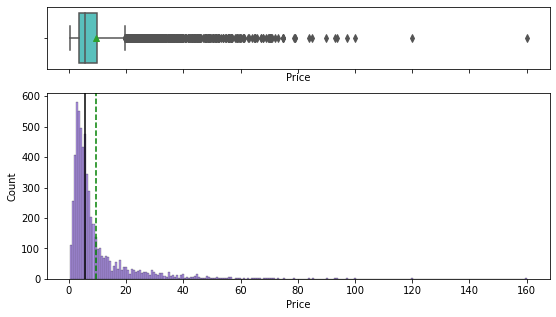

In [880]:
# Plotting the Price variable
histogram_boxplot(data = df, feature = 'Price')

**Observation:**  
The target variable (price) is very right skewed. It shows that most cars are between 0 - 10 dollars. There are outliers present, with the maximum price being 160 dollars which seems quite high for a used car. The median is very far from the mean as seen in the plot. 

One of the assumptions of linear regression is that the target variable is normally distributed. Hence, log transformation would be used to achieve this.

**Log_Price**

In [881]:
# log transformation of the target variable (Price) and renaming it to a new variable Log_Price
df['Log_Price'] = np.log(df['Price'])

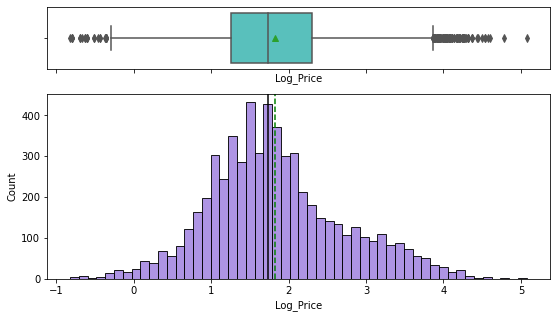

In [882]:
# Plotting the Log_Price variable
histogram_boxplot(data = df, feature = 'Log_Price')

**Observation:**  
The median is now closer to the mean, but outliers still persist on the lower and upper side of the distribution.

**Kilometers_Driven**

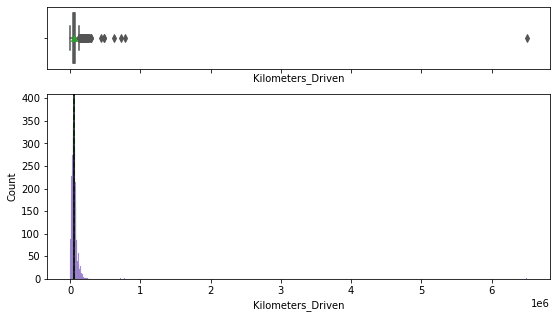

In [883]:
# plotting the Kilometers_Driven visualisation
histogram_boxplot(data = df, feature = 'Kilometers_Driven')

In [884]:
#getting the maximum value
max_km = df['Kilometers_Driven'].max()

#subsetting the data
df[df['Kilometers_Driven'] == max_km]

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Mileage_Unit,Brand_Name,Car_Age,Log_Price
2328,BMW X5 xDrive 30d M Sport,Chennai,2017,6500000,Diesel,Automatic,First,15.97,2993.0,258.0,5.0,55.07,65.0,kmpl,BMW,6,4.174387


**Observation:**  
The median is close to the mean, but the distribution is moderately right-skewed beacuse the max value is very high and unusual. This is an outlier, as a 6 year old car could not possibly have a mileage reading of 6500000. 

**Mileage**

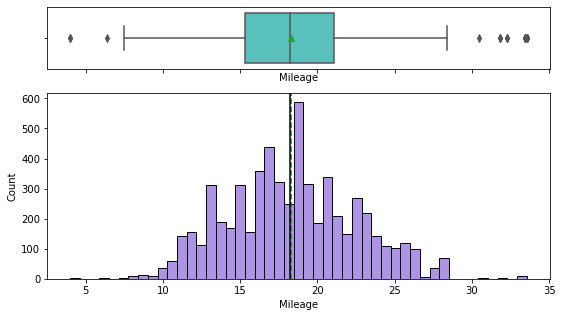

In [885]:
# Plotting the Log_Price variable
histogram_boxplot(data = df, feature = 'Mileage')

**Observation:**  
The Mileage column seems to be normally distributed. There are few outliers on the lower and upper ends of the plot.

**Engine**

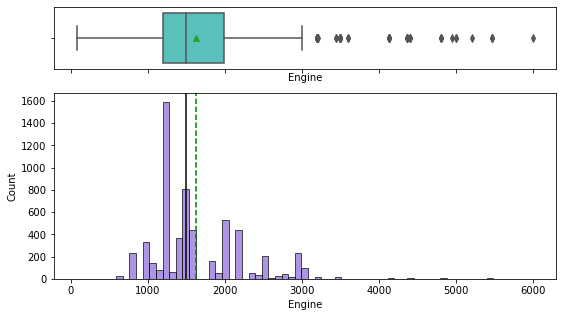

In [886]:
# Plotting the Engine variable
histogram_boxplot(data = df, feature = 'Engine')

**Observation:**  
The Engine column is slightly right skewed because of the presence of powerful high-speed cars. However, the most common car engine displacement volume is about 1200CC, and most cars have between 1000CC and 2000CC.

**Power**

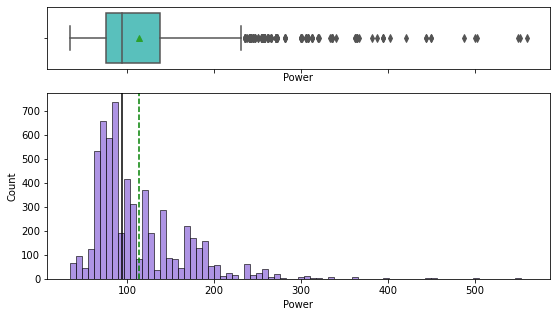

In [887]:
# Plotting the Power variable
histogram_boxplot(data = df, feature = 'Power')

**Observation:**  
The Power column is right skewed as most of the values are between 0 to about 130. The mean is also very far from the median.

**Location**

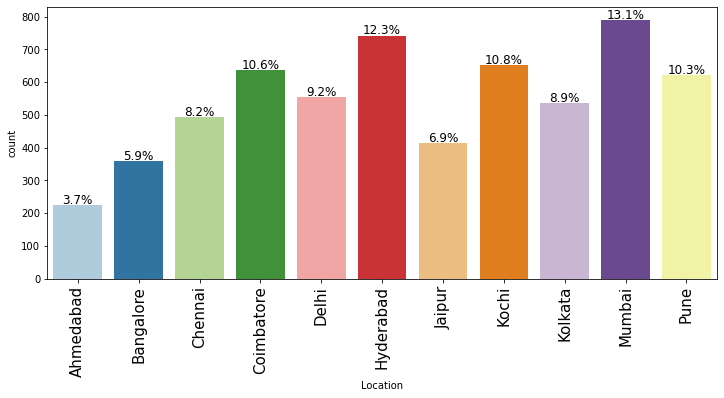

In [888]:
# plotting the Location variable
labeled_barplot(df, "Location", perc=True)

Most cars are sold in Mumbai with 13.1% of the market-share, followed by Hyderabad at 12.3% and Kochi at 10.8%.  
This could point to the fact that the population here can afford to buy the cars and/or these locations are prime spots for the pre-owned cars business.

**Year**

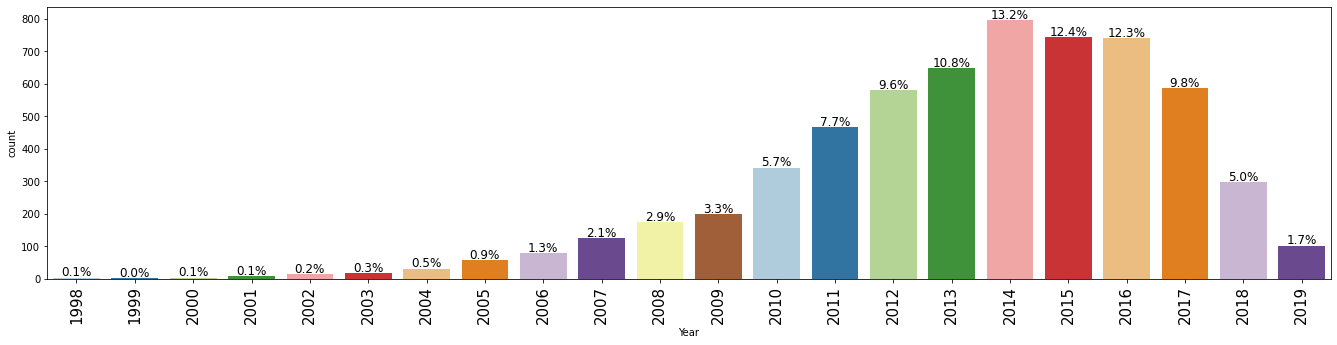

In [889]:
# plotting the Year variable
labeled_barplot(df, "Year", perc=True)

The plot shows that most cars sold are manufactured between 2012 and 2017, with 2014 being the highest at 13.2%.  
This could point to the fact that people are not predisposed to buying older model cars, and much newer models may be too expensive to purchase, except for a select few that can afford it.

**Car Age**

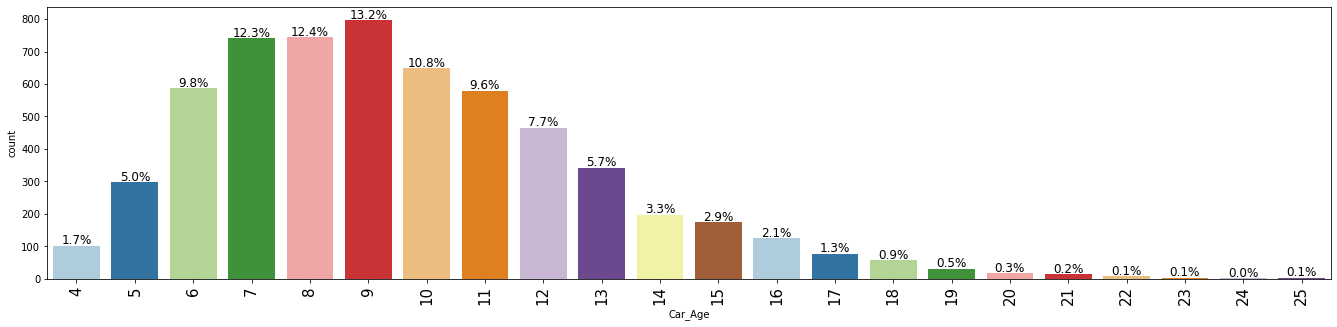

In [890]:
# plotting the Car_Age variable
labeled_barplot(df, "Car_Age", perc=True)

As seen in the year plot, it can be confirmed that cars between 6 and 11 years sell faster. Highest selling cars are 9 years with 13.2%.

**Fuel_Type**

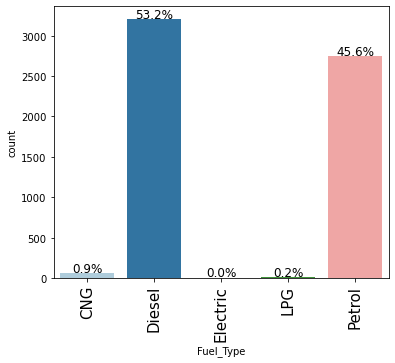

In [891]:
# plotting the Fuel_Type variable
labeled_barplot(df, "Fuel_Type", perc=True)

Most cars use Diesel (53.2%) and Petrol (45.6%) as fuel. CNG (0.9%) and LPG (0.2%) are not common with Electric even more so.

**Transmission**

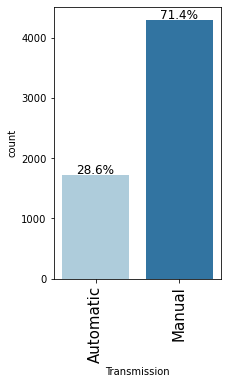

In [892]:
# plotting the Transmission variable
labeled_barplot(df, "Transmission", perc=True)

Manual cars (71.4%) are more popular than Automatic cars (28.6%)

**Owner Type**

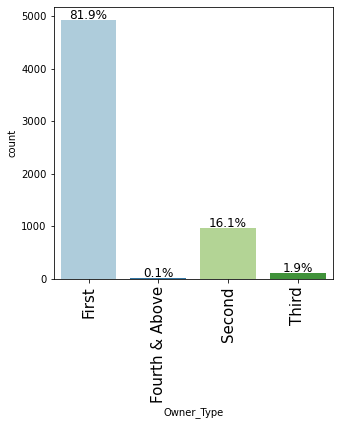

In [893]:
# plotting the Owner_Type variable
labeled_barplot(df, "Owner_Type", perc=True)

First-owned cars are more popular among buyers at 81.9%. The plot shows that the more owners a car has, the less its selling value. This would be confirmed in the bivariate analysis

**Seats**

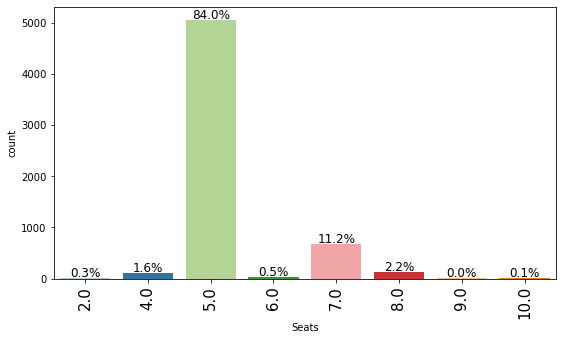

In [894]:
# plotting the Seats variable
labeled_barplot(df, "Seats", perc=True)

Most cars have 5 seats (84.0%). This could point to the fact that cars with 5 seats are cheaper. Alternatively, cars with 2 seats are less common and could point to the fact that they are more expensive.

**Brand Name**

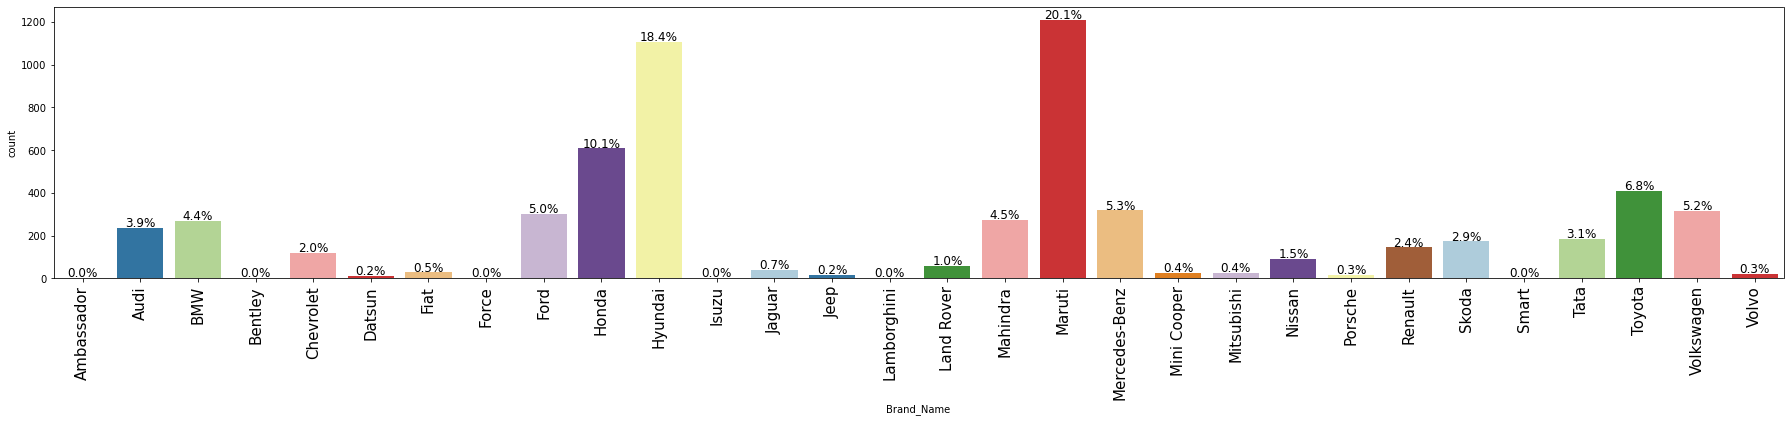

In [895]:
# plotting the Brand_Name variable
labeled_barplot(df, "Brand_Name", perc=True)

Maruti (20.1%), Hyundai (18.4%) and Honda (10.1%) are the most popular car brands. A bivariate plot of this variable with the target variable would be done to further understand why.

### Bivariate Analysis

**Correlation between numerical variables**

/var/folders/2k/0kq3ns6d15zc29hhnqxvjj2m0000gp/T/ipykernel_2321/1262897864.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f")


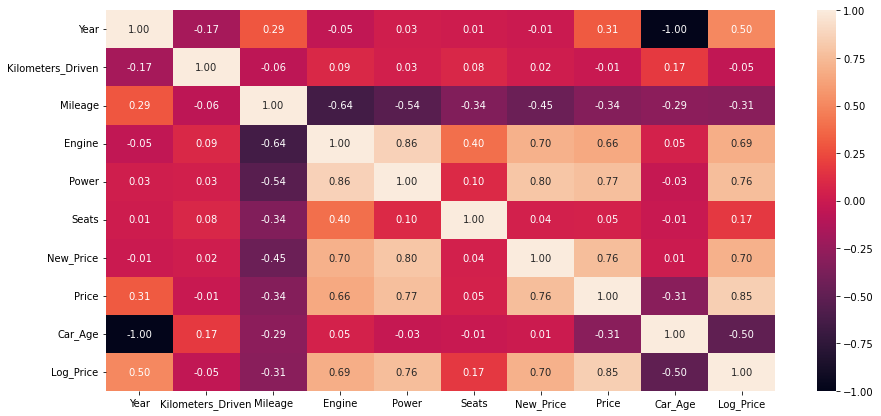

In [896]:
plt.figure(figsize=(15, 7))
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f")
plt.show()

**Observation:**  
- There is a low correlation between the price and the year of manufacture, also as expected, the car age has a negative correlation with price. The older a car is, the lower its price. Log_Price however is moderately correlated with year and moderately negatively correlated with car age.  
- Mileage is negatively moderately correlated with Engine and Power. That means the more power and engine capacity a car has, the less fuel efficient it is.
- Engine has a high correlation with Power. The more engine capacity, the more power the car generates. This also applies to all price values. Cars with bigger engine capacity tend to be more expensive.
- We can also see that Engine is highly correlated with power, therefore only one of these variables is needed to build the model. New_price, Price and Log_Price are highly correlated with each other. I would be using the Log_Price to build the model.
- Car age and Year are similar, and contibute the same to the target and other independent variables. I would be using the car age in the model.

### Other bivariate analysis

**Brand vs Log Price**

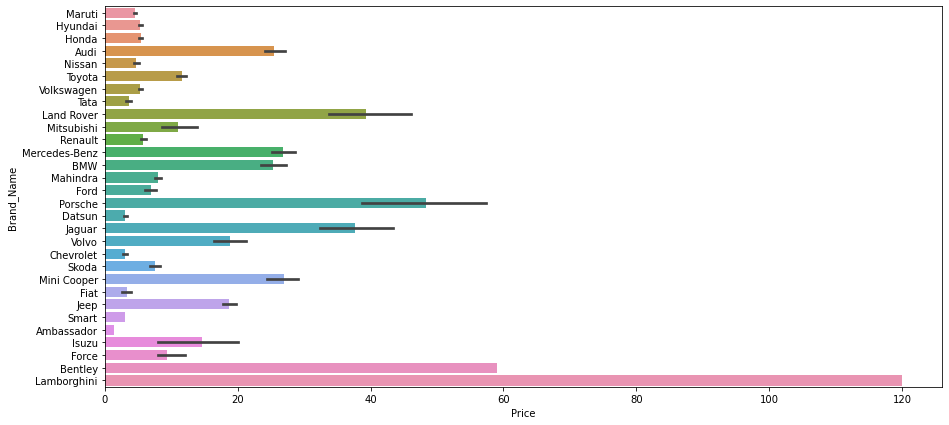

In [897]:
plt.figure(figsize=(15, 7))
sns.barplot(x="Price", y="Brand_Name", data=df)
plt.show()

As suspected, Maruti, Hyundai and Honda brands are cheap brands hence their popularity.

**Location vs Price**

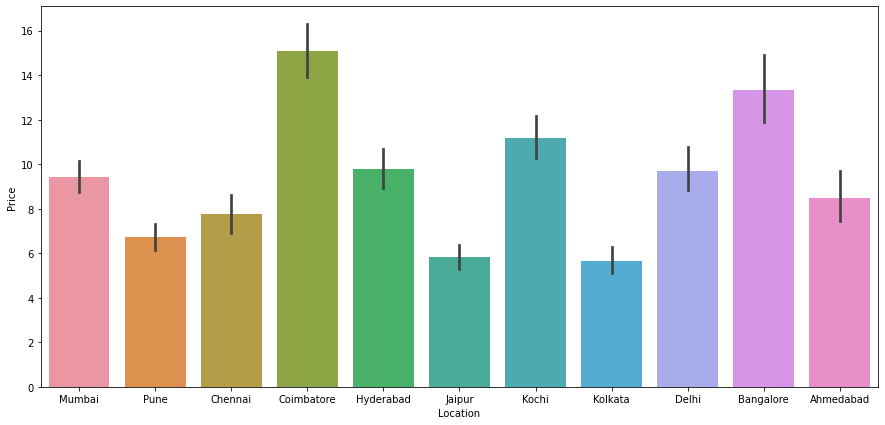

In [898]:
plt.figure(figsize=(15, 7))
sns.barplot(x="Location", y="Price", data=df)
plt.show()

It can be seen that cars in Mumbai, Hyderabad and Kochi, which are the most popular locations, are moderately priced and have similar ranges. This is probably the attraction as prices here are fairly standardized. It would be beneficial to the business to break into the market in these locations so as not to be shunned in locations of high prices or lose out of potential profit from lower price regions.

Cars are more expensive in Coimbatore and Bangalore, while places like Jaipur, Kolta and Pune have low prices. 

**Car Age vs Price**

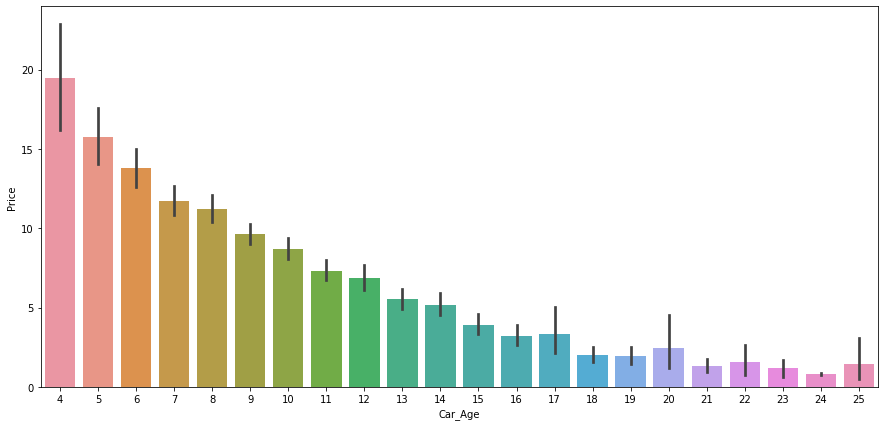

In [899]:
plt.figure(figsize=(15, 7))
sns.barplot(x="Car_Age", y="Price", data=df)
plt.show()

The newer a car model, the more expensive it is.

**Fuel Type vs Price**

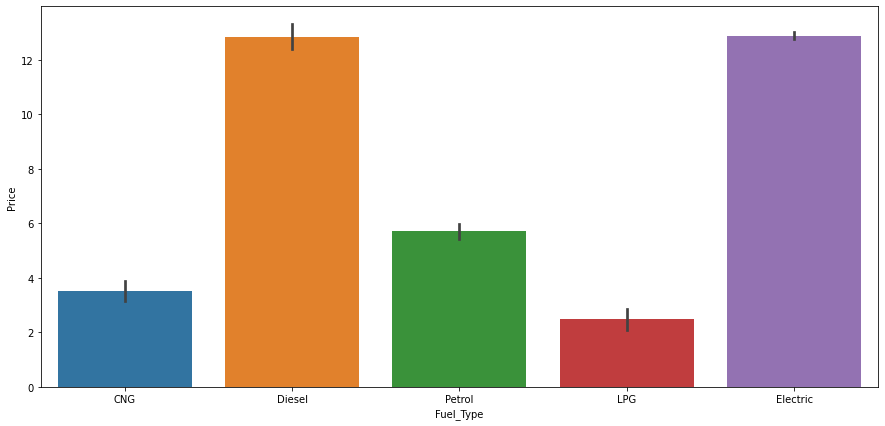

In [900]:
plt.figure(figsize=(15, 7))
sns.barplot(x="Fuel_Type", y="Price", data=df)
plt.show()

Diesel, Electric and Petrol cars are more expensive that others. 

**Transmission vs Price**

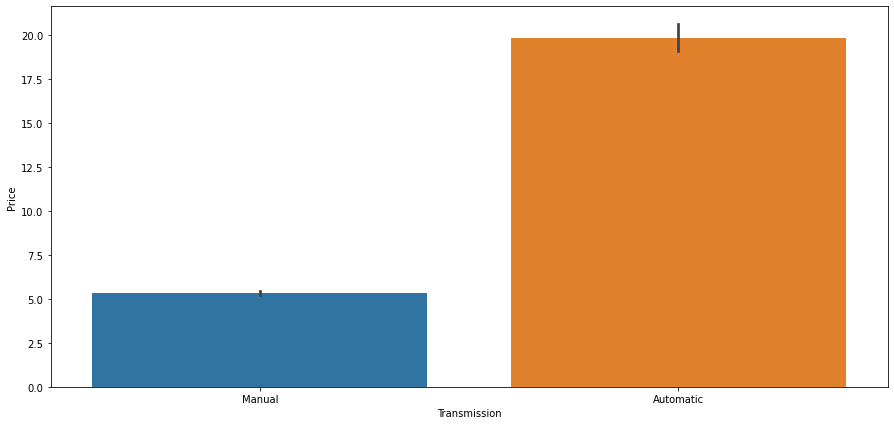

In [901]:
plt.figure(figsize=(15, 7))
sns.barplot(x="Transmission", y="Price", data=df)
plt.show()

Automatic cars cost more than Manual cars, hence the popularity of manual cars over automatic cars.

**Owner Type vs Price**

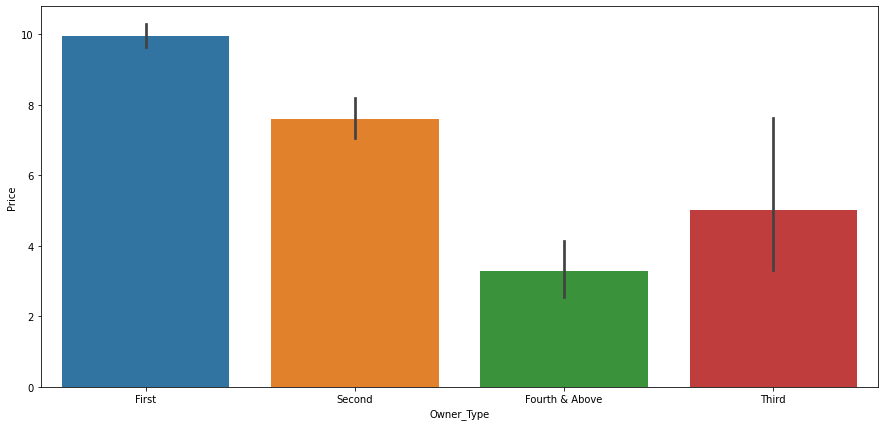

In [902]:
plt.figure(figsize=(15, 7))
sns.barplot(x="Owner_Type", y="Price", data=df)
plt.show()

The more owners a car has had, the less expensive it is. However, customers would still tend to go for first owner cars because there is probably a high chance it has been properly maintained by the initial owner, and hence would not cause a liability to the customer.

**Seats vs Price**

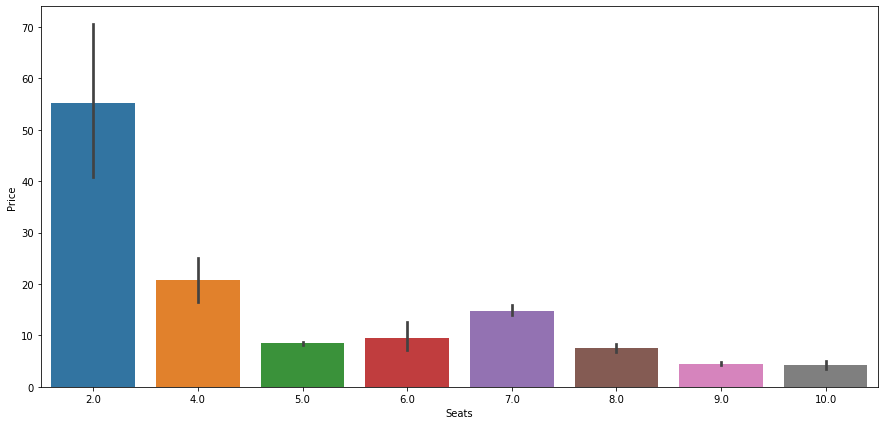

In [903]:
plt.figure(figsize=(15, 7))
sns.barplot(x="Seats", y="Price", data=df)
plt.show()

Cars with two seats cost the most (probably sports cars), followed by 4 seats and then 7 seats. Cars with 5 seats are relatively cheaper, hence their popularity over the others.

**Outlier Treatment on Numerical Variables**

In [904]:
# Creating a new numerical column variable to include newly created variables
new_num_cols = df.select_dtypes(include='number').columns.to_list()
new_num_cols

['Year',
 'Kilometers_Driven',
 'Mileage',
 'Engine',
 'Power',
 'Seats',
 'New_Price',
 'Price',
 'Car_Age',
 'Log_Price']

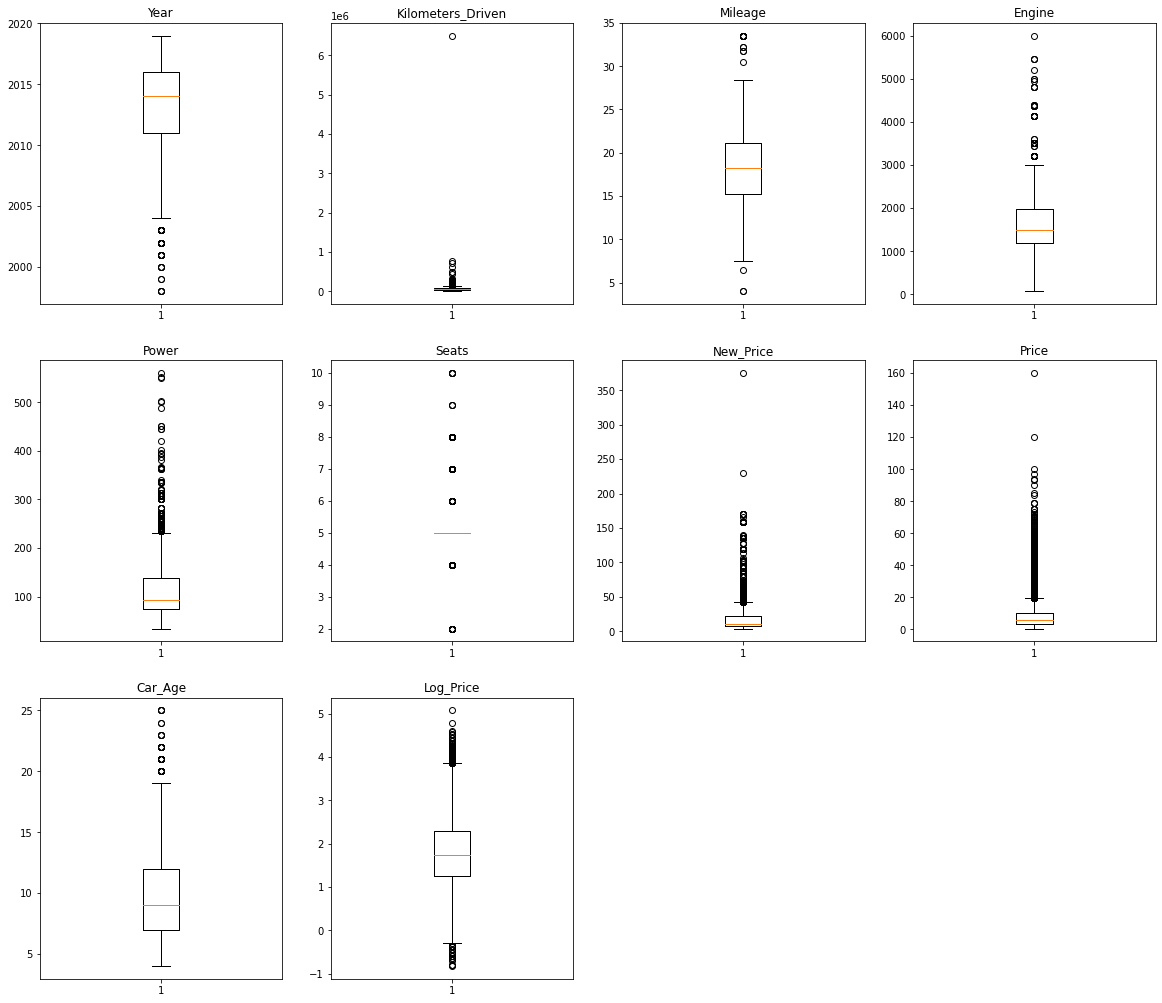

In [905]:
# outlier detection using boxplot
plt.figure(figsize=(20, 30))

for i, variable in enumerate(new_num_cols):
    plt.subplot(5, 4, i + 1)
    plt.boxplot(df[variable])
#     plt.tight_layout()  # to avoid the title from overlapping
    plt.title(variable)
plt.savefig('out.png')
plt.show()

All the numerical variables have outliers, including the target which has only upper outliers. The log_price has both upper and lower outliers. 

In [906]:
# Statistical description of the data set with the new numerical variables
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,6019.0,2013.358199,3.269742,1998.000000,2011.000000,2014.000000,2016.000000,2.019000e+03
Kilometers_Driven,6019.0,58738.380296,91268.843206,171.000000,34000.000000,53000.000000,73000.000000,6.500000e+06
Mileage,6019.0,18.321744,4.171318,4.000000,15.290000,18.200000,21.100000,3.354000e+01
Engine,6019.0,1620.431135,600.404083,72.000000,1197.000000,1493.000000,1984.000000,5.998000e+03
Power,6019.0,112.928242,53.635865,34.200000,75.000000,93.700000,138.100000,5.600000e+02
Seats,6019.0,5.277953,0.803778,2.000000,5.000000,5.000000,5.000000,1.000000e+01
New_Price,6019.0,21.499855,24.332922,3.910000,7.880000,11.300000,21.770000,3.750000e+02
Price,6019.0,9.479468,11.187917,0.440000,3.500000,5.640000,9.950000,1.600000e+02
Car_Age,6019.0,9.641801,3.269742,4.000000,7.000000,9.000000,12.000000,2.500000e+01
Log_Price,6019.0,1.825095,0.874059,-0.820981,1.252763,1.729884,2.297573,5.075174e+00


In [907]:
# treating outliers in a particular column
def treat_outliers(df, col):
    """
    treats outliers in a varaible
    col: str, name of the numerical varaible
    df: data frame
    col: name of the column
    """
    Q1 = df[col].quantile(0.25)  # 25th quantile
    Q3 = df[col].quantile(0.75)  # 75th quantile
    IQR = Q3 - Q1
    Lower_Whisker = Q1 - 1.5 * IQR
    Upper_Whisker = Q3 + 1.5 * IQR
    df[col] = np.clip(
        df[col], Lower_Whisker, Upper_Whisker
    )  # all the values samller than Lower_Whisker will be assigned value of Lower_whisker
    # and all the values above upper_whisker will be assigned value of upper_Whisker
    return df

# treating outliers on all columns
def treat_outliers_all(df, col_list):
    """
    treat outlier in all numerical varaibles
    col_list: list of numerical varaibles
    df: data frame
    """
    for c in col_list:
        df = treat_outliers(df, c)

    return df

In [908]:
# treating the outliers in the columns in the treated_num_cols list
df = treat_outliers_all(df, new_num_cols)

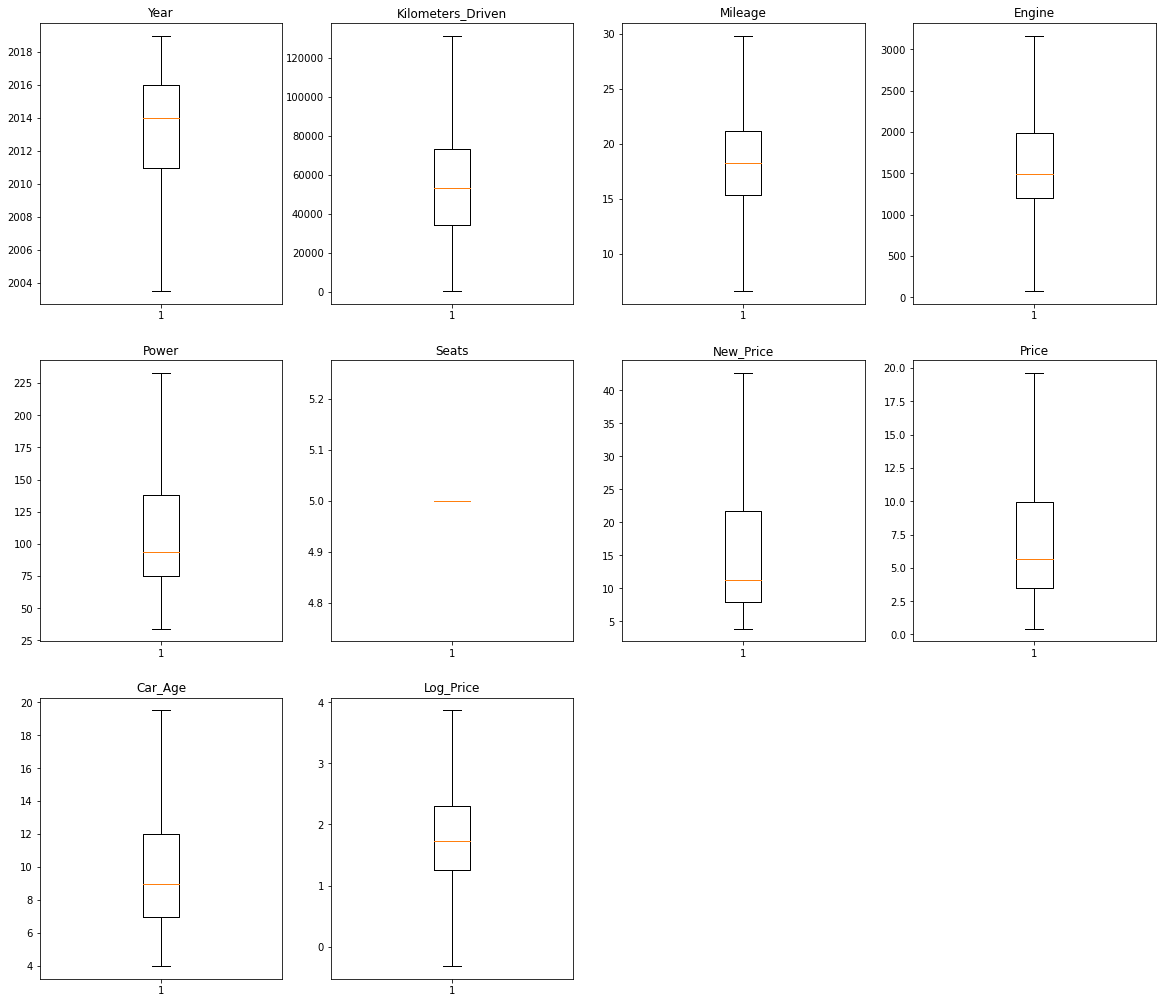

In [909]:
# let's look at the boxplots to see if the outliers have been treated or not
plt.figure(figsize=(20, 30))

for i, variable in enumerate(new_num_cols):
    plt.subplot(5, 4, i + 1)
    plt.boxplot(df[variable], whis=1.5)
    #plt.tight_layout()
    plt.title(variable)

plt.savefig('out_treated.png')
plt.show()

All outliers have been sucessfully treated

### Building the Model

**Select the Features and the Target**

In [910]:
#training data (we drop the target column) and other multicolinear or unnecessary columns
X = df.drop(['Year', 'New_Price', 'Price', 'Log_Price', 'Name', 'Brand_Name', 'Engine'], axis=1) 
y = df['Log_Price'] #target data

**Creating dummy variables**

In [911]:
# This is a method of one hot encoding categorical variables to convert them to numerical variables
X = pd.get_dummies(X, drop_first=True)

In [912]:
#Getting the dimension of the X data after creating dummy variables
X.shape

(6019, 25)

**Split data into train and test sets**

In [913]:
# splitting the data into train and test sets. We will use 80% to train and 20% to test
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

**Data normalization**

In [914]:
# create an instance of the scaler
scaler = StandardScaler() #using standard scaler

# scale the train data
x_train_sc = scaler.fit_transform(x_train)

# scale the test data
x_test_sc = scaler.transform(x_test)

**Fit the Linear Regression Model**

In [915]:
# create an instance of the model
lin_reg = LinearRegression()

# train the model
lin_reg.fit(x_train_sc, y_train)

LinearRegression()

In [916]:
lin_reg.coef_

array([-6.09786793e-02, -8.33332118e-02,  4.82741474e-01,  2.30418882e+10,
       -3.69934336e-01,  3.60080141e-02,  5.04779123e-03,  2.41780374e-02,
       -1.79729704e-02,  4.09556447e-02, -1.90205496e-02, -1.22420903e-02,
       -7.71498006e-02, -2.30350436e-02, -1.70162511e-02, -8.49607060e+10,
       -1.65876348e+12, -5.87179262e-03, -8.48211435e+10, -9.54075198e-02,
        2.20573070e-03, -2.82251597e-02, -1.93605602e-02,  1.79277399e+10,
        1.65876348e+12])

**Performance Metrics**

In [917]:
# function to compute adjusted R-squared
def adj_r2_score(predictors, targets, predictions):
    """
    predictors: independent variables in the data
    targets: real values of the dependent variable
    predictions: predicted values of the dependent variable
    """
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0] #number of rows in the data
    k = predictors.shape[1] #number of columns in the data
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1)) #formular for adjusted r2

# function to compute MAPE
def mape_score(targets, predictions):
    return np.mean(np.abs(targets - predictions) / targets) * 100


# function to compute different metrics to check performance of a regression model
def model_performance_regression(model, predictors, target):
    """
    Function to compute different metrics to check regression model performance

    model: regressor
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    r2 = r2_score(target, pred)  # to compute R-squared
    adjr2 = adj_r2_score(predictors, target, pred)  # to compute adjusted R-squared
    rmse = np.sqrt(mean_squared_error(target, pred))  # to compute RMSE
    mae = mean_absolute_error(target, pred)  # to compute MAE
    mape = mape_score(target, pred)  # to compute MAPE

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Root_Mean_Squared_Error": rmse,
            "Mean_Absolute_Error": mae,
            "R_squared": r2,
            "Adjusted_R_squared": adjr2,
            "Mean_Absolute_Percentage_Error": mape
        },
        index=[0],
    )

    return df_perf

**Model performance on the train set**

In [918]:
# checking the performance on the train set
model_train_pf = model_performance_regression(lin_reg, x_train_sc, y_train)
model_train_pf

,Root_Mean_Squared_Error,Mean_Absolute_Error,R_squared,Adjusted_R_squared,Mean_Absolute_Percentage_Error
0,0.279946,0.209087,0.893797,0.893242,inf


**Model performance on the test set**

In [919]:
# checking the performance on the test set
model_test_pf = model_performance_regression(lin_reg, x_test_sc, y_test)
model_test_pf

,Root_Mean_Squared_Error,Mean_Absolute_Error,R_squared,Adjusted_R_squared,Mean_Absolute_Percentage_Error
0,0.281047,0.208046,0.894177,0.891931,inf


- From the above performance on the train and test data, it can be observed that the model generalizes well because the train accuracy is close to the test accuracy.
- It can be interpreted that when this model is fed new data similar to the one used to train it, it would accurately predict the price of the car approx. 89% of the time.
- The RMSE is 27.9 on the train data and 28.1 on the test data
- The MAE is 20.9 on the train data and 20.8 on the test data
- The MAPE on both the test and train data is infinite. This is caused by the negative value in the log_price variable

### Ridge Regression

In [920]:
# create an instance of the model and setting alpha to 2.0
ridge = Ridge(alpha=2.0)

# train the model
ridge.fit(x_train_sc, y_train)

Ridge(alpha=2.0)

In [921]:
# checking the performance on the train set
ridge_train_pf = model_performance_regression(ridge, x_train_sc, y_train)
ridge_train_pf

,Root_Mean_Squared_Error,Mean_Absolute_Error,R_squared,Adjusted_R_squared,Mean_Absolute_Percentage_Error
0,0.279941,0.209082,0.893801,0.893246,inf


In [922]:
# checking the performance on the test set
ridge_train_pf = model_performance_regression(ridge, x_test_sc, y_test)
ridge_train_pf

,Root_Mean_Squared_Error,Mean_Absolute_Error,R_squared,Adjusted_R_squared,Mean_Absolute_Percentage_Error
0,0.280941,0.208005,0.894256,0.892012,inf


The values for the ridge regression are similar to that of the Linear regression for both test and train data.

From the ridge regression, it can be interpreted that when this model is fed new data similar to the one used to train it, it would accurately predict the price of the car approx. 89% of the time.
- The RMSE is 27.9 on the train data and 28.1 on the test data
- The MAE is 20.9 on the train data and 20.8 on the test data
- The MAPE on both the test and train data is infinite. This is caused by the negative value in the log_price variable

### Forward Feature Selection

In [923]:
# import the SequentialFeatureSelector from the feature_selection module
from mlxtend.feature_selection import SequentialFeatureSelector

# create an instance of the sequential feature selector
# estimator is the model (we've selected the linear regression model)
# k_features let's you choose how many variables you want to use (we chose use all variables in the code below)...
# ... because we are doing the forward feature selection.
# for the backward selection, the "forward" hyperparameter is set to "False"
# n_jobs let's you choose how many cores of your computer you want to use to run the program. -1 means use all
# verbose helps to print the process on the screen
sfs = SequentialFeatureSelector(estimator=lin_reg, k_features=x_train.shape[1], n_jobs=-1, verbose=2)

# build the sequential feature selector
sfs.fit(x_train_sc, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    6.8s finished

[2023-02-05 23:16:08] Features: 1/25 -- score: 0.6120524562284417[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.2s finished

[2023-02-05 23:16:09] Features: 2/25 -- score: 0.8458781893361783[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    0.3s finished

[2023-02-05 23:16:09] Features: 3/25 -- score: 0.8621268091744442[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    0.2s finished

[2023-02-05 23:16:09] Features: 4/25 -- score: 0.8707212007867013[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  21 | elapsed:    0.2s remaining:

SequentialFeatureSelector(estimator=LinearRegression(), k_features=(25, 25),
                          n_jobs=-1, scoring='r2', verbose=2)

**Plotting the performance**

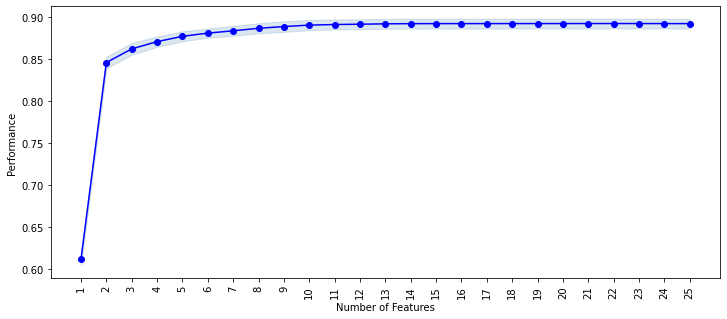

In [924]:
# importing the plotting function
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

# plotting the standard error 
fig1 = plot_sfs(sfs.get_metric_dict(), kind="std_err", figsize = (12, 5))
plt.xticks(rotation = 90)
plt.show()

From the graph above, the performance of the model improved drastically after just 2 variables were added, but gradually continued to improve from then till the addition of the 10th feature, after which improvement was not significant.

**Rebuilding the Model with just 10 features**

In [925]:
# create an instance of the sequential feature selector
sfs = SequentialFeatureSelector(estimator=lin_reg, k_features=10, n_jobs=-1, verbose=2)

# build the sequential feature selector
sfs.fit(x_train_sc, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  25 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.3s finished

[2023-02-05 23:16:13] Features: 1/10 -- score: 0.6120524562284417[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.2s finished

[2023-02-05 23:16:13] Features: 2/10 -- score: 0.8458781893361783[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    0.2s finished

[2023-02-05 23:16:13] Features: 3/10 -- score: 0.8621268091744442[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    0.2s finished

[2023-02-05 23:16:13] Features: 4/10 -- score: 0.8707212007867013[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent 

SequentialFeatureSelector(estimator=LinearRegression(), k_features=(10, 10),
                          n_jobs=-1, scoring='r2', verbose=2)

**Selecting the important features**

In [926]:
# k_feature_indx_ is the index of the important variables in the dataset
print(sfs.k_feature_idx_)

(0, 1, 2, 4, 5, 7, 9, 12, 15, 19)


In [927]:
# Converting the tuple of the indexes to a list
feat_cols = list(sfs.k_feature_idx_)
print(feat_cols)

[0, 1, 2, 4, 5, 7, 9, 12, 15, 19]


In [928]:
# Look at the most important features
# Passing in the index of the important variables to get the names of the variables
x_train.columns[feat_cols]

Index(['Kilometers_Driven', 'Mileage', 'Power', 'Car_Age',
       'Location_Bangalore', 'Location_Coimbatore', 'Location_Hyderabad',
       'Location_Kolkata', 'Fuel_Type_Diesel', 'Transmission_Manual'],
      dtype='object')

In [929]:
# select the important features in training and test sets
x_train_new = x_train[x_train.columns[feat_cols]] #This gives us the actual data contained in the train columns
x_test_new = x_test[x_train.columns[feat_cols]] #This gives us the actual data contained in the test columns

In [930]:
# Normalise the new train and test datasets
scaler_new = StandardScaler()

# scale the train and test data sets
x_train_new_sc = scaler_new.fit_transform(x_train_new)
x_test_new_sc = scaler_new.transform(x_test_new)

**Rebuilding the Linear Regression Model**

In [931]:
# create an instance of the model
lin_reg2 = LinearRegression()

# train the model
lin_reg2.fit(x_train_new_sc, y_train)

LinearRegression()

**Checking the model's performance**

In [932]:
# check the performance of the train data
model_performance_regression(lin_reg2, x_train_new_sc, y_train)

,Root_Mean_Squared_Error,Mean_Absolute_Error,R_squared,Adjusted_R_squared,Mean_Absolute_Percentage_Error
0,0.283331,0.21168,0.891213,0.890987,inf


In [933]:
# check the performance of the test data
model_performance_regression(lin_reg2, x_test_new_sc, y_test)

,Root_Mean_Squared_Error,Mean_Absolute_Error,R_squared,Adjusted_R_squared,Mean_Absolute_Percentage_Error
0,0.283066,0.20886,0.89265,0.891751,inf


All three models gave similar error and accuracy percentages.
- From the model above, it can be interpreted that when this model is fed new data similar to the one used to train it, it would accurately predict the price of the car approx. 89% of the time.
- The RMSE is 28.3 on the train data and 28.3 on the test data
- The MAE is 21.1 on the train data and 20.8 on the test data
- The MAPE on both the test and train data is infinite. This is caused by the negative value in the log_price variable

**Plotting the correlation matrix of the important variables with the target variable**

In [934]:
#converting the target variable to a dataframe
df_target = y.to_frame(name='Log_Price')
df_target

,Log_Price
0,0.559616
1,2.525729
2,1.504077
3,1.791759
4,2.875822
...,...
6014,1.558145
6015,1.386294
6016,1.064711
6017,0.974560


In [935]:
# Getting the important variables
important_df = X[X.columns[feat_cols]]
important_df

,Kilometers_Driven,Mileage,Power,Car_Age,Location_Bangalore,Location_Coimbatore,Location_Hyderabad,Location_Kolkata,Fuel_Type_Diesel,Transmission_Manual
0,72000,26.60,58.16,13.0,0,0,0,0,0,1
1,41000,19.67,126.20,8.0,0,0,0,0,1,1
2,46000,18.20,88.70,12.0,0,0,0,0,0,1
3,87000,20.77,88.76,11.0,0,0,0,0,1,1
4,40670,15.20,140.80,10.0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
6014,27365,28.40,74.00,9.0,0,0,0,0,1,1
6015,100000,24.40,71.00,8.0,0,0,0,0,1,1
6016,55000,14.00,112.00,11.0,0,0,0,0,1,1
6017,46000,18.90,67.10,10.0,0,0,0,1,0,1


In [936]:
# merging the target dataframe with the important variables dataframe
important_df = important_df.assign(Log_Price = df_target['Log_Price'])
important_df

,Kilometers_Driven,Mileage,Power,Car_Age,Location_Bangalore,Location_Coimbatore,Location_Hyderabad,Location_Kolkata,Fuel_Type_Diesel,Transmission_Manual,Log_Price
0,72000,26.60,58.16,13.0,0,0,0,0,0,1,0.559616
1,41000,19.67,126.20,8.0,0,0,0,0,1,1,2.525729
2,46000,18.20,88.70,12.0,0,0,0,0,0,1,1.504077
3,87000,20.77,88.76,11.0,0,0,0,0,1,1,1.791759
4,40670,15.20,140.80,10.0,0,1,0,0,1,0,2.875822
...,...,...,...,...,...,...,...,...,...,...,...
6014,27365,28.40,74.00,9.0,0,0,0,0,1,1,1.558145
6015,100000,24.40,71.00,8.0,0,0,0,0,1,1,1.386294
6016,55000,14.00,112.00,11.0,0,0,0,0,1,1,1.064711
6017,46000,18.90,67.10,10.0,0,0,0,1,0,1,0.974560


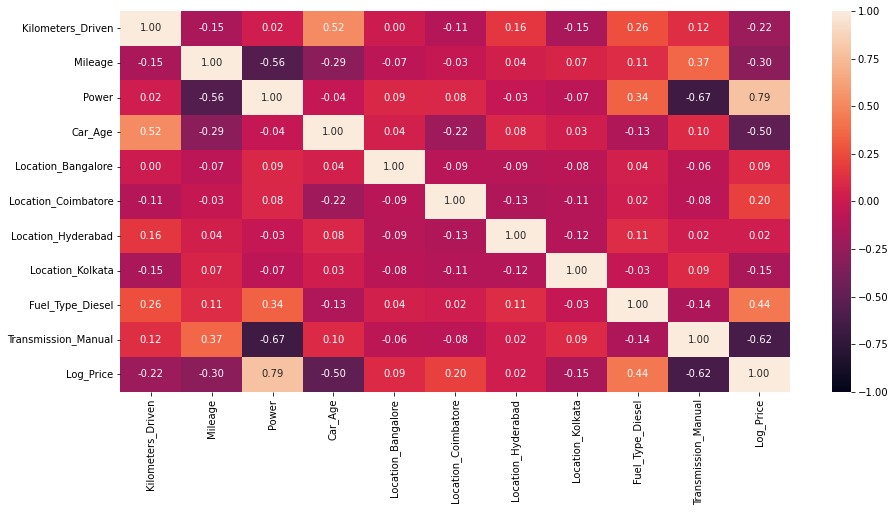

In [937]:
# Plotting the correlation between the important variables and the target variable
plt.figure(figsize=(15, 7))
sns.heatmap(important_df.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f")
plt.show()

**Observation**
- Power has a strong positive correlation with the target variable.
- Car_Age and Transmission_Manual are moderately negatively correlated with the target variable
- Fuel_TypeType_Diesel has a low positive correlation with the target variable
- Mileage has a low negative correlation with the target variable

### Results

Since the performance of the model did not improve after feature selection, we can say that we have been able to build the model and achieve similar results with a smaller number of variables. This would be beneficial to the business as a cost-saving initiative.

### Recommendations

From the insights gathered from the visualisations, the following recommendations is presented to Cars4U:  

1. Mumbai, Hyderabad and Kochi are the locations where most cars are purchased. This is due to the fact that cars sold in these places are moderately priced. It would be beneficial to focus business and marketing strenght in these areas for a chance at profitability. Higher priced location may prove to be too much competition as the business is yet to establish a brand presence and build consumer trust. Alternatively, lower priced locations run the risk of reduced profitability for the business.  


2. Customers are more predisposed to cars with the following specifications:
- Car Age: 6 - 11 years (Not too old to be a liability and not too new to be expensive)
- Fuel Type: Diesel and Petrol (This is the preferred vehicle fuel type for consumers)
- Transmission: Manual (Less expensive than the automatic counterparts)
- Car Seats: 5 seats (Generally less expensive that other cars with higher or lower number of seats)
- Owner Type: First Owner (Less expensive to maintain in the long run, as the probability for the car developing a fault is low due to proper maintenanance from the first owner).  
It is recommended that the company starts by selling pre-owned cars with these specifications, before gradually expanding to other specifications.